# Short term prediction for beaches affluences

This model can predict affluences up to a single hour in the future.

## Imports

In [76]:
from matplotlib.pyplot import figure, show
from multiprocessing import Pool
from sklearn import cross_validation
from sklearn import metrics
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import datetime
import dateutil.parser
import json
import math
import matplotlib.dates as mdates
import os
import pandas as pd
import pylab as plt
import pytz
import scipy
import sys
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

## Loading datas

Load all datas from the `../data/` directory.

In [29]:
def json_from_file(relative_path):
    with open(relative_path) as fs:
        return json.load(fs)

weather = json_from_file('../data/weather.json')
tides = json_from_file('../data/tides.json')
places = json_from_file("../data/sensors/all_places_infos.json")

#roads = pd.read_json("../data/scrappers/ordered.json")
#roads['date'] = roads.apply(lambda row: str(row['date'] - datetime.timedelta(minutes = row['date'].minute % 30)), axis = 1)
#roads = roads.groupby('date').max()

## Initializing vars

You can change the `up_to` variable to change the number of days from now we'll need weather (if the first measure is one year in the past, you have to set `up_to` to 365).

In [30]:
up_to = 100

allsensors = []
base = datetime.datetime.today()
week_day = {"Mon": 0,
        "Tue": 1,
        "Wed": 2,
        "Thu": 3,
        "Fri": 4,
        "Sat": 5,
        "Sun": 6}

paris = pytz.timezone('Europe/Paris')
utc = pytz.utc

date_list = {}
for x in range(0, up_to):
    date_list[(base - datetime.timedelta(days = x)).strftime("%Y-%m-%d")] = []
    
try:
    os.stat("data")
except:
    os.mkdir("data")

## Useful functions

In [5]:
def retrieve_hour(measure):
    date = dateutil.parser.parse(measure["date"])
    date = date - datetime.timedelta(minutes = date.minute % 30, seconds = date.second, microseconds = date.microsecond)
    return date

def retrieve_nb_measured(measure):
    try:
        return len(measure["value"])
    except:
        return measure["value"]

def get_level(median, nb):
    if (nb <= median):
        return (0)
    if (nb <= 2 * median):
        return (1)
    return (2)

def get_weather(date, hour, what):
    try:
        return weather[str(date.year)][str(date.month)][str(date.day)][what][str(hour)]
    except:
        return 0

def get_prev(df, date, nb_hours):
    date = date - datetime.timedelta(hours = nb_hours)
    if (date in df.index):
        return df.loc[date]["Nb_measured"]
    return 0

def get_roads_affluence(row):
    try:
        date = str(row.name - datetime.timedelta(hours = 1, minutes = 0))
        date = date[:10] + ' ' + date[11:19]
        val = roads.affluence[date]
        return val
    except:
        return 0

def set_shift(row):
    dt = row["Date"] - datetime.timedelta(minutes = row["Date"].minute % 30)
    return dt.strftime("%Y%M%d%H%m")

## Processing data

Process data for each sensor in order to have a better learning set.

In [44]:
data = pd.DataFrame()
for sensor in places:
    measures = json_from_file("../data/sensors/sensor-" + str(sensor["id"]) + "_wifi.json")
    
    print "Processing sensor: \"" + sensor["name"].encode("utf-8") + "\"..."
    if (len(measures) < 150):
        print "  No measures acquired, aborting process."
        continue

    df = pd.DataFrame(data = list(zip(map(retrieve_hour, measures), map(retrieve_nb_measured, measures))), columns = ["Date", "Nb_measured"])

    df["Day"]                 = df.apply(lambda row: row["Date"].date(), axis = 1)
    days_df = df.groupby("Day").max()
    days_df = days_df[days_df["Nb_measured"] < 50]
    for i in days_df.index:
        df = df[df["Day"] != i]
    del df["Day"]

    # Grouping duplicates:
    df = df.groupby("Date").mean()

    # Adding features
    df["Previous"]            = df.apply(lambda row: get_prev(df, row.name, 1), axis = 1)          # Reduces mean error by 10, actually it may avoid too large breaks between two predictions
    df["Day_of_week"]         = df.apply(lambda row: week_day[row.name.strftime("%a")], axis = 1)
    df["Hour_of_day"]         = df.apply(lambda row: row.name.hour, axis = 1)
    df["Weather_Temperature"] = df.apply(lambda row: get_weather(row.name, row.name.hour, "temperature"), axis = 1)
    df["Level"]               = df.apply(lambda row: (get_level(100, row["Nb_measured"])), axis = 1)
    df["id"] = sensor["sensor_ids"][0]
    data = data.append(df)

data.to_csv("data/dataset_sensors.csv")

Processing sensor: "Le grand Crohot"...
Processing sensor: "Le Porge"...
Processing sensor: "Carcans (plage centrale)"...
Processing sensor: "Bombannes"...
Processing sensor: "HQ"...
  No measures acquired, aborting process.
Processing sensor: "Lacanau SuperSud"...


------------

# Learning part

You can start process over here if you already saved data from the previous lines.

This script will test the efficiency of the model an print a graph with the predictions and the real measures overlapping to have a look at the efficacity.

## Init


In [35]:
try:
    places
except:
    places = json_from_file("../data/sensors/all_places_infos.json")

clf           = DecisionTreeRegressor(max_depth = 8)
print data


Empty DataFrame
Columns: []
Index: []


## Collecting data

In [45]:
df = pd.read_csv("data/dataset_sensors.csv", index_col = "Date", parse_dates = True)
    
NB_days = 4
today = datetime.datetime.today()
limit = today - datetime.timedelta(days = NB_days)

Y = df[df.index < limit]["Nb_measured"]
future_Y = df[df.index > limit]["Nb_measured"]

del df["Level"]
del df["Nb_measured"]

X = df[df.index < limit]
future_X = df[df.index > limit]


## Evaluation

This part will output the root of the MSE (square root of the Mean Squared Error) from the cross validation algorithm.

In [46]:
cv = cross_validation.ShuffleSplit(X.shape[0], test_size = 0.2, random_state = 0, n_iter = 100)
scores = cross_validation.cross_val_score(clf, X, Y, scoring = "mean_squared_error", cv = cv)
print("   Mean error of %0.2f (+/- %0.2f)" % (math.sqrt(-scores.mean()), math.sqrt(scores.std() if scores.std() >= 0 else -scores.std())))

   Mean error of 35.10 (+/- 12.32)


## Feature importance

This part is supposed to output the features importance of the tree from all the features given in the aggregating part ("**Processing data**'s subpart).

In [51]:
clf.fit(X, Y)

predicted = pd.Series(clf.predict(future_X), index = future_X.index)
learned = pd.Series(clf.predict(X), index = X.index)
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import pearsonr

rmse = sqrt(mean_squared_error(future_Y, predicted))
pearson = pearsonr(future_Y, predicted)
print 'RMSE : ', rmse
print 'PEAR : ', pearson[0]
print
print "Features importance: "
for i, feature in enumerate(X.columns):
    print "   " + feature + ": " + str(clf.feature_importances_[i])




RMSE :  48.5114739467
PEAR :  0.955870434323

Features importance: 
   Previous: 0.865924116156
   Day_of_week: 0.00130697522952
   Hour_of_day: 0.120753474955
   Weather_Temperature: 0.00725642508931
   id: 0.00475900856925


## Graph

In green, we have the test curve. Measures under the green curve wasn't used to fit the model.
In purple, we have the learning curve; measures under it were the measures used to fit.

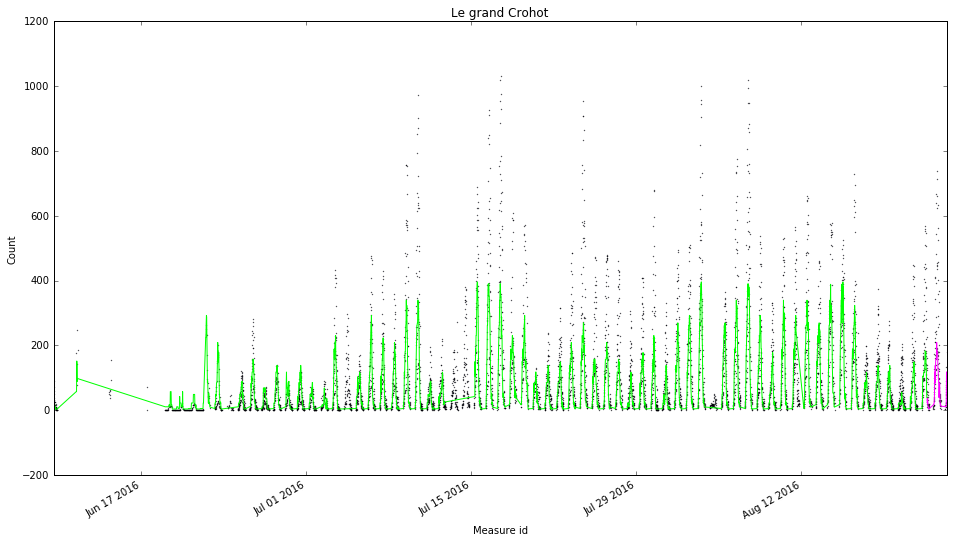

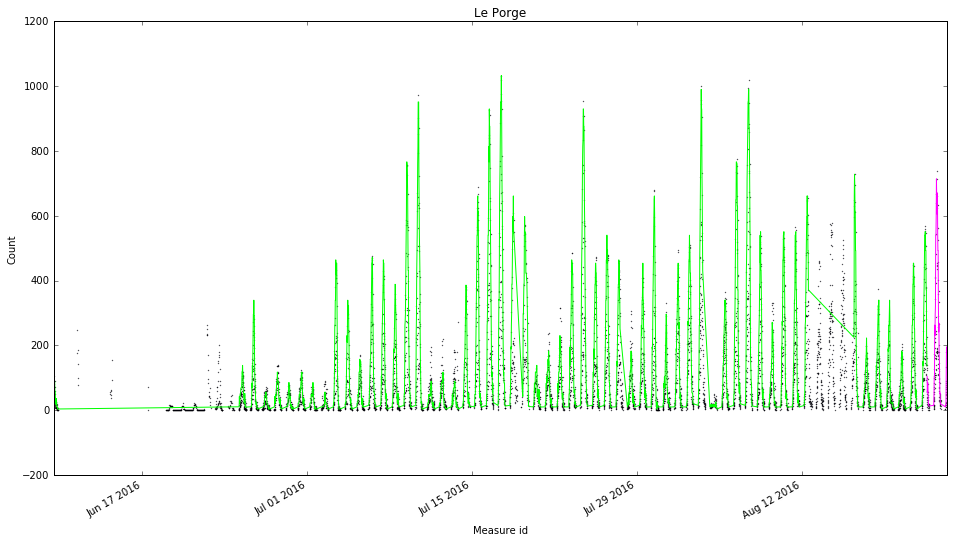

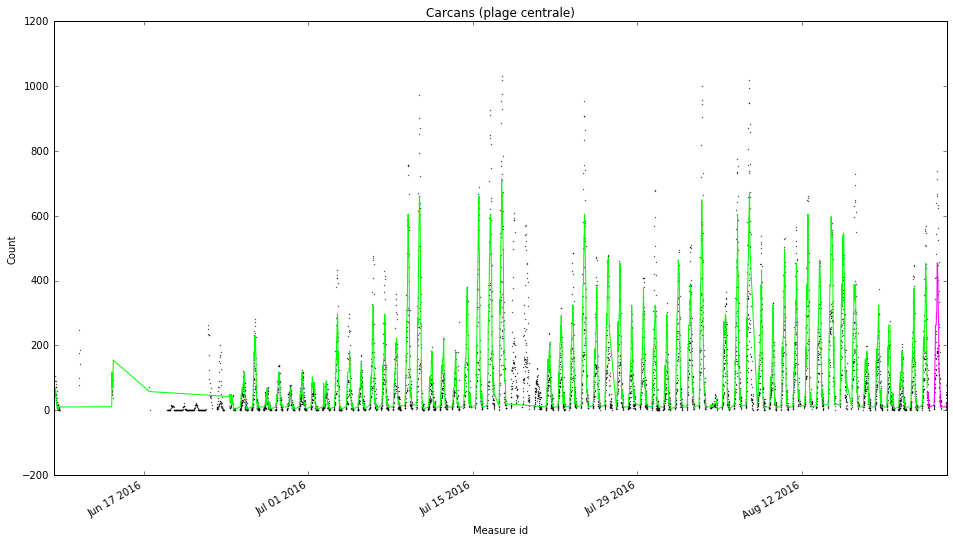

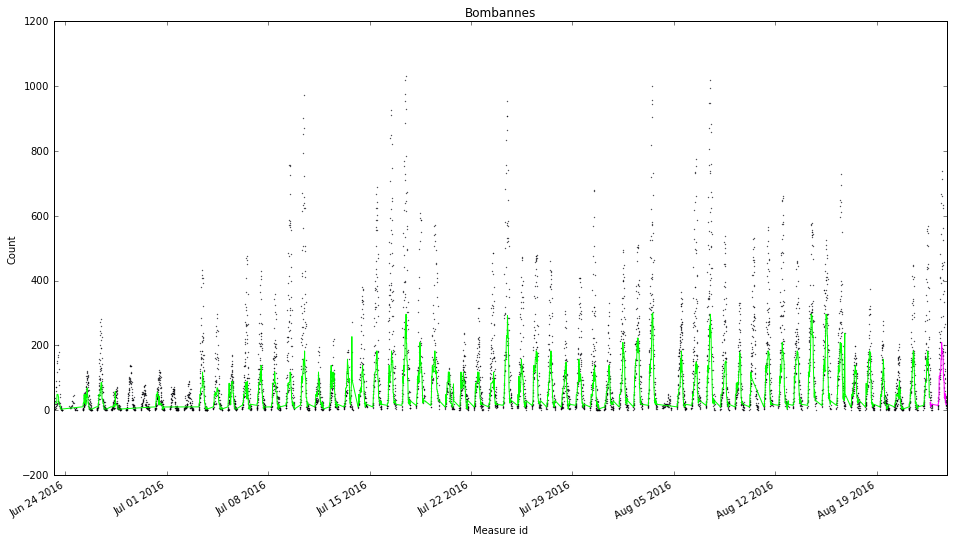

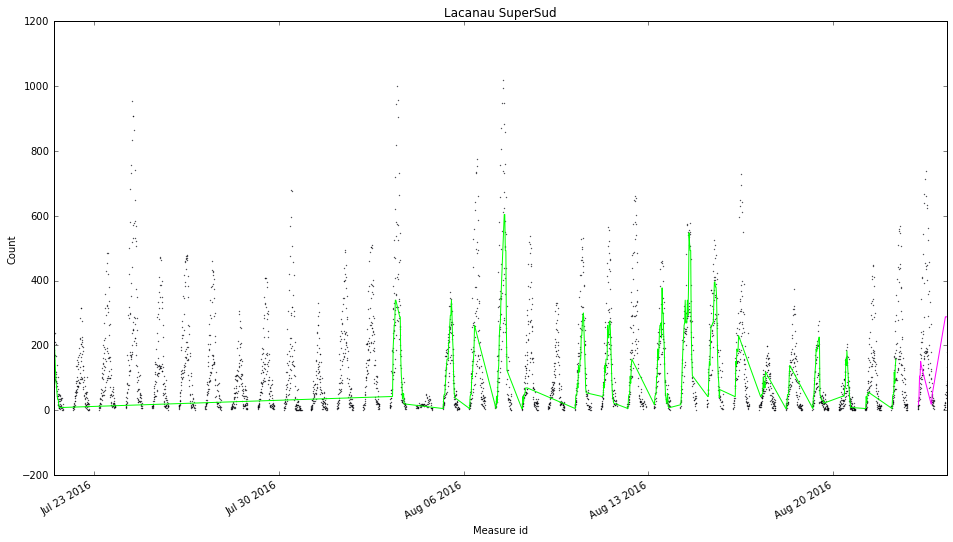

In [92]:
for place in places:
    cur = place["sensor_ids"][0]

    if cur:
        a = learned[X["id"] == cur]
        b = predicted[future_X["id"] == cur]

        measures1 = plt.scatter(Y.index, Y, s=0.1)
        measures2 = plt.scatter(future_Y.index, future_Y, s=0.1)
        a.plot(c = "#00ff00")
        b.plot(c = "#FF00ff")

        #plt.legend([measures1, aa, bb], ["Measured", "Predicted", "Learned"], loc = "best")
        plt.xlabel("Measure id")
        plt.ylabel("Count")
        plt.title(place["name"])
        plt.figure()
plt.show()

# Prediction

Here you'll have the prediction up to an hour in the future for the sensor given in `sensor_id`.

In [11]:
sensor_id = '1'

In [93]:
from __future__ import division

weather_forecast = json_from_file('../data/weather_forecast.json')
weather_temperatures = weather_forecast["hourly"]["data"]

def totimestamp(dt, epoch=datetime.datetime(1970,1,1)):
    td = dt - epoch
    # return td.total_seconds()
    return int(((td.seconds + td.days * 86400) * 10**6) / 10**6) + 3600

def retrieve_measure(date):
    val = totimestamp(date.replace(tzinfo = None))
    for i in weather_temperatures:
        if i["time"] == val:
            return i

date_from = dateutil.parser.parse(by_sensor[sensor_id].iloc[len(by_sensor[sensor_id]) - 1].name)

day_of_week = week_day[date_from.strftime("%a")]
hour_of_day = date_from.hour + 1
temperature = retrieve_measure(date_from)["temperature"]

print "Date: " + str(date_from + datetime.timedelta(hours = 1))

for place in places:
    sensor_id = str(place['id'])
    
    try:
        previous    = by_sensor[sensor_id].iloc[len(by_sensor[sensor_id]) - 1]
    except:
        continue
    res = int(clf.predict([[
                    previous,
                    day_of_week,
                    hour_of_day,
                    temperature,
                    sensor_id
                ]])[0])

    print "  Expected: " + str(res) + " persons at " + place['name']

#print json.dumps(weather_temperature, indent=4, sort_keys=True)

IOError: [Errno 2] No such file or directory: '../data/weather_forecast.json'